In [1]:
# !pip install convertdate LunarCalendar holidays



In [2]:
import pandas as pd
from neuralprophet import NeuralProphet
from sklearn.metrics import mean_squared_error
import numpy as np
# plotting
import matplotlib.pyplot as plt
from neuralprophet.plot_forecast import plot_forecast_component
# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [3]:
%config InlineBackend.figure_format = 'retina'


In [4]:
cash = pd.read_csv('train.csv')

print(f'The dataset contains {len(cash)} observations.')
cash.head()

The dataset contains 425 observations.


,periode,cash_in_echannel,cash_out_echannel,cash_in_kantor,cash_out_kantor,cr_ketetapan_total_bkn_sum,giro,deposito,kewajiban_lain,tabungan,rata_dpk_mingguan,kas_kantor,kas_echannel
0,2019-07-31,7.303000e+08,-1.304400e+09,1.436722e+11,-1.106104e+11,3.0,9.867358e+11,8.048153e+11,1.419685e+10,7.072647e+11,3.135744e+11,1.928940e+09,2.939100e+09
1,2019-08-01,7.322000e+08,-8.321500e+08,3.144131e+11,-6.710987e+10,3.0,8.962459e+11,8.125611e+11,1.234062e+10,7.011995e+11,3.135744e+11,2.492322e+11,2.839150e+09
2,2019-08-02,1.169800e+09,-6.214000e+08,1.251294e+09,-1.142332e+09,3.0,9.059714e+11,8.127225e+11,1.182022e+10,6.922787e+11,3.135744e+11,2.493411e+11,3.387550e+09
3,2019-08-03,9.134500e+08,-4.240500e+08,0.000000e+00,0.000000e+00,3.0,9.057127e+11,8.127253e+11,1.199640e+10,6.867224e+11,3.135744e+11,2.493411e+11,3.876950e+09
4,2019-08-04,7.752500e+08,-7.779500e+08,9.883331e+10,-8.729274e+10,3.0,9.788347e+11,8.124711e+11,1.232962e+10,6.813438e+11,3.135744e+11,2.608817e+11,3.874250e+09


In [5]:
cash['periode'] = pd.to_datetime(cash['periode'])
cash.sort_values('periode', inplace=True)
cash['kas_kantor_verif'] = cash['kas_kantor'].shift()+cash['cash_in_kantor'] + cash['cash_out_kantor']
cash['kas_echannel_verif'] = cash['kas_echannel'].shift()+cash['cash_in_echannel'] + cash['cash_out_echannel']

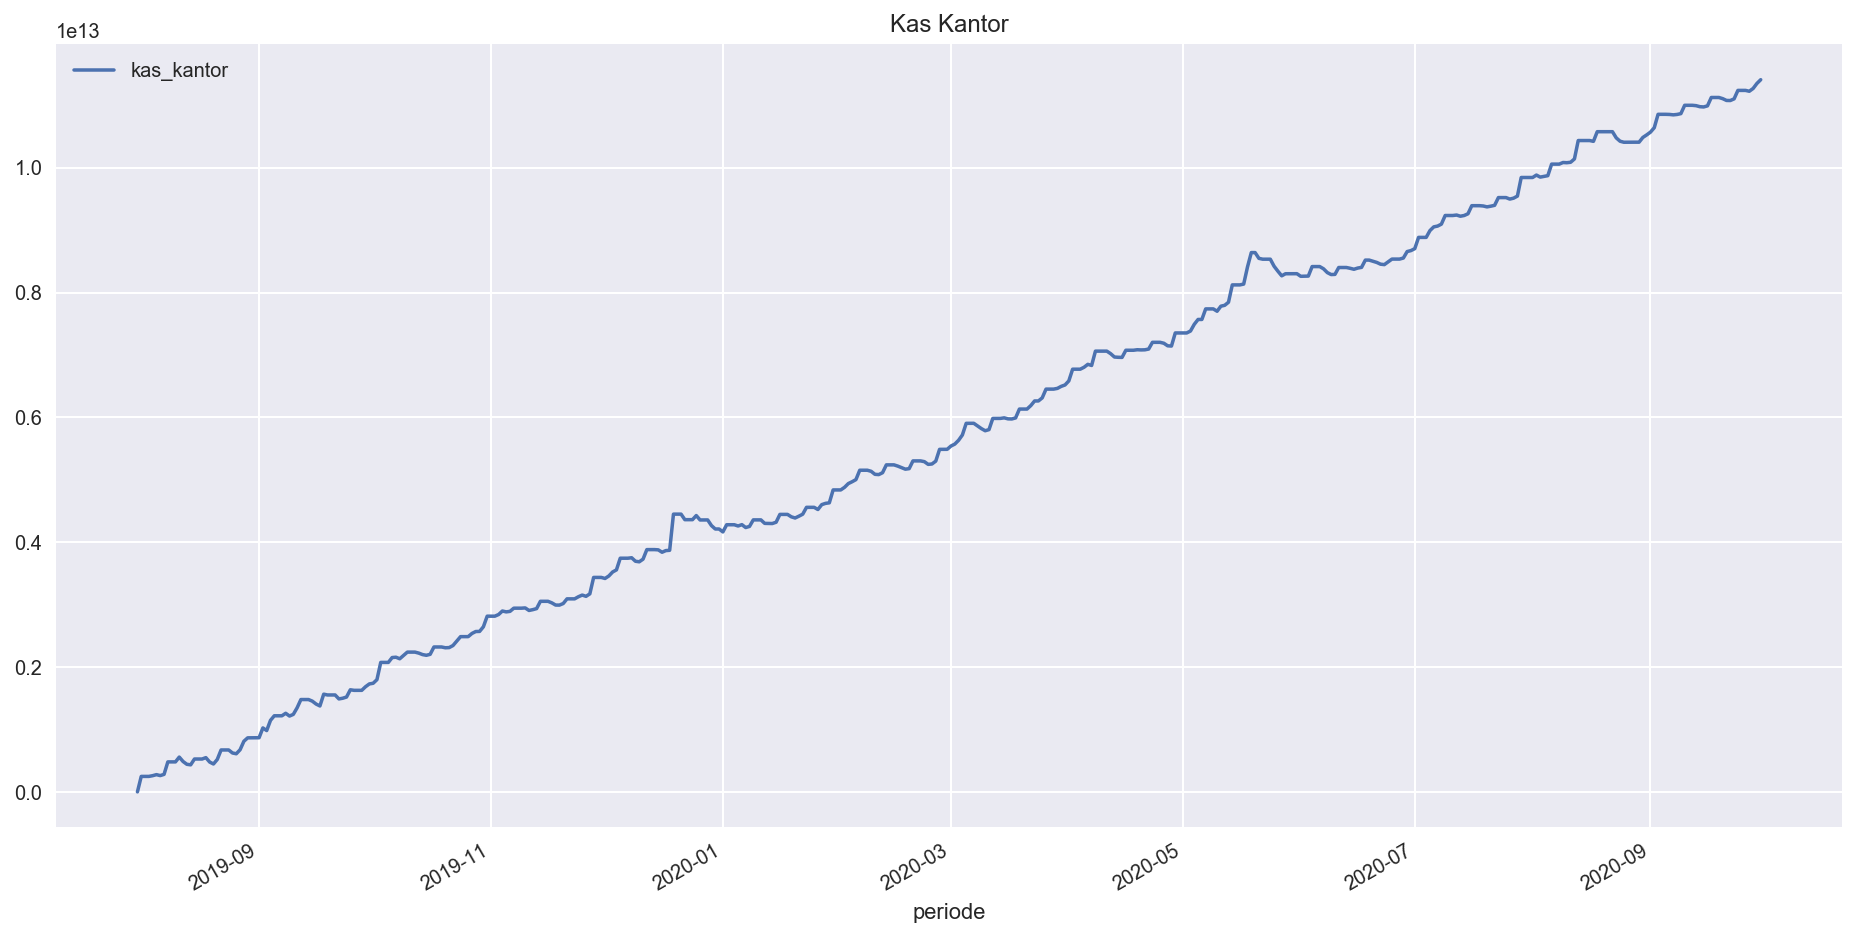

In [6]:
cash.plot(x='periode', y='kas_kantor', title='Kas Kantor');


In [7]:
daily_kas_kantor = cash[['periode', 'kas_kantor']].rename(
    columns={'periode': 'ds',
             'kas_kantor': 'y'})

# Take 80% data for training

# daily_kas_kantor = cash[['periode', 'kas_kantor']].head(int(len(cash)*(80/100))).rename(
#     columns={'periode': 'ds',
#              'kas_kantor': 'y'})

daily_kas_kantor.head()
test_length = 31

In [8]:
daily_kas_kantor

,ds,y
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11
...,...,...
420,2020-09-26,1.123736e+13
421,2020-09-27,1.122373e+13
422,2020-09-28,1.126813e+13
423,2020-09-29,1.134856e+13


In [9]:
Covid = pd.DataFrame({
    'holiday': 'Covid',
    'ds': pd.to_datetime(['2020-05-19']), # future date, to be forecasted
    'lower_window': -1, # include 27th - 31st December
    'upper_window': 1})

Kemerdekaan = pd.DataFrame({
    'holiday': 'Kemerdekaan',
    'ds': pd.to_datetime(['2020-08-17']), # future date, to be forecasted
    'lower_window': -1, # include 27th - 31st December
    'upper_window': 1})

Natal = pd.DataFrame({
    'holiday': 'Natal',
    'ds': pd.to_datetime(['2020-12-25', # past date, historical data 
                          '2021-12-25']), # future date, to be forecasted
    'lower_window': -10, # include 27th - 31st December
    'upper_window': 0})

holiday_kantor = pd.concat([Covid,Kemerdekaan,Natal], axis=0).reset_index(drop=True)
holiday_kantor

,holiday,ds,lower_window,upper_window
0,Covid,2020-05-19,-1,1
1,Kemerdekaan,2020-08-17,-1,1
2,Natal,2020-12-25,-10,0
3,Natal,2021-12-25,-10,0


# Neural Prophet Model - Kas Kantor

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
daily_kas_kantor = cash[['periode', 'kas_kantor']].rename(
    columns={'periode': 'ds',
             'kas_kantor': 'y'})
model_holiday_indo_kantor = NeuralProphet(
    growth='linear',
    changepoints=None,
    n_changepoints=5,
    changepoints_range=0.85,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='additive',
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=32,
    d_hidden=32,
    ar_sparsity=0.2,
    learning_rate=None,
    epochs=None,
    batch_size=None,
    loss_func='Huber',
    train_speed=None,
    normalize='auto',
    impute_missing=True,
    log_level=None)
# model_holiday_indo_kantor.add_events(holiday_kantor)
model_holiday_indo_kantor.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_holiday_indo_kantor.add_country_holidays(country_name='ID')
model_holiday_indo_kantor.fit(daily_kas_kantor, freq="D",validate_each_epoch=True,valid_p=0.2,)

future_kantor = model_holiday_indo_kantor.make_future_dataframe(daily_kas_kantor, 
                                                 periods = test_length, 
                                                 n_historic_predictions=len(daily_kas_kantor))
# forecasting
forecast_kantor = model_holiday_indo_kantor.predict(future_kantor)


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py", l

  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2932, in _run_cell
    return runner(coro)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3156, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3347, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-7c0545907fbd>", line 31, in <module>
    model_holiday_indo_kantor.add_country_holidays(c

Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
  

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 8

INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 94
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\farha\Anaco

  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 1.00E-01
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\

Epoch[94/94]: 100%|█| 94/94 [00:06<00:00, 14.96it/s, SmoothL1Loss=9.43e-5, MAE=9.64e+10, RegLoss=0, MAE_val=1.49e+11, S
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    

MSE comparison ----
NeuralProphet:	0.1475


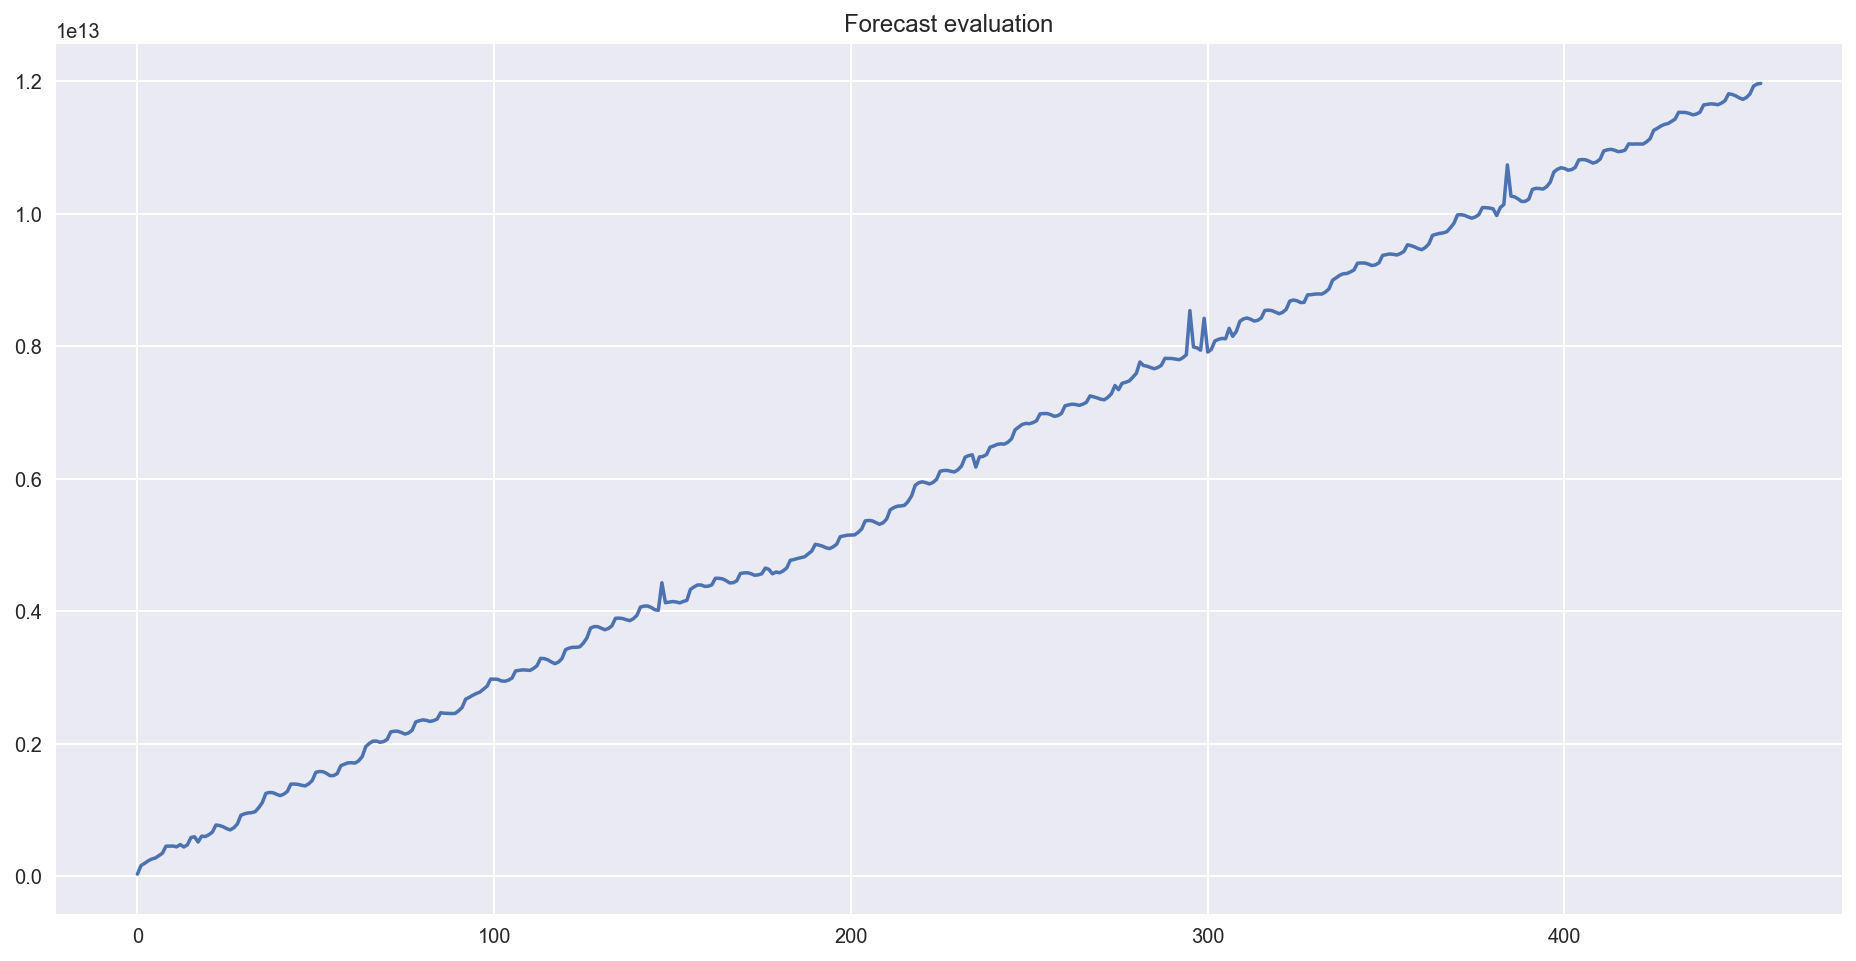

In [85]:
# I know about chained indexing here, but it was just faster and more elegant then using iloc and column index
from sklearn.metrics import mean_squared_log_error

# prepping the DataFrame
forecast= forecast_kantor.loc[:, 'yhat1']
# forecast_kantor.set_index('ds', inplace=True)

print('MSE comparison ----')
# print(f"NeuralProphet:\t{mean_squared_error(forecast_kantor['y'], forecast_kantor.iloc[-test_length:]['yhat1']):.4f}")
print(f"NeuralProphet:\t{np.sqrt(mean_squared_log_error(forecast_kantor['yhat1'].head(425),daily_kas_kantor.loc[:,'y'])):.4f}")

forecast.plot(title='Forecast evaluation');

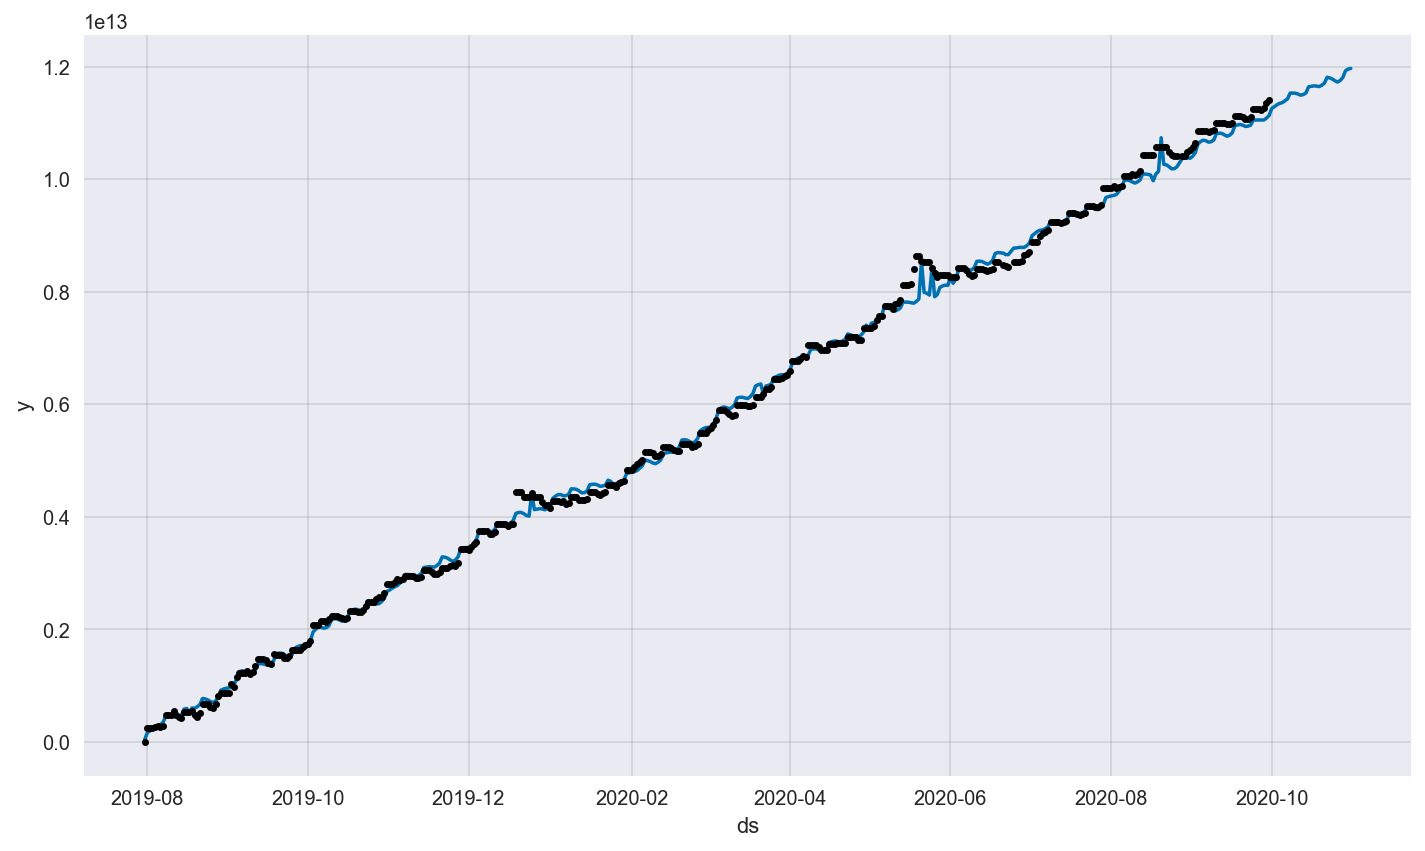

In [86]:
model_holiday_indo_kantor.plot(forecast_kantor);

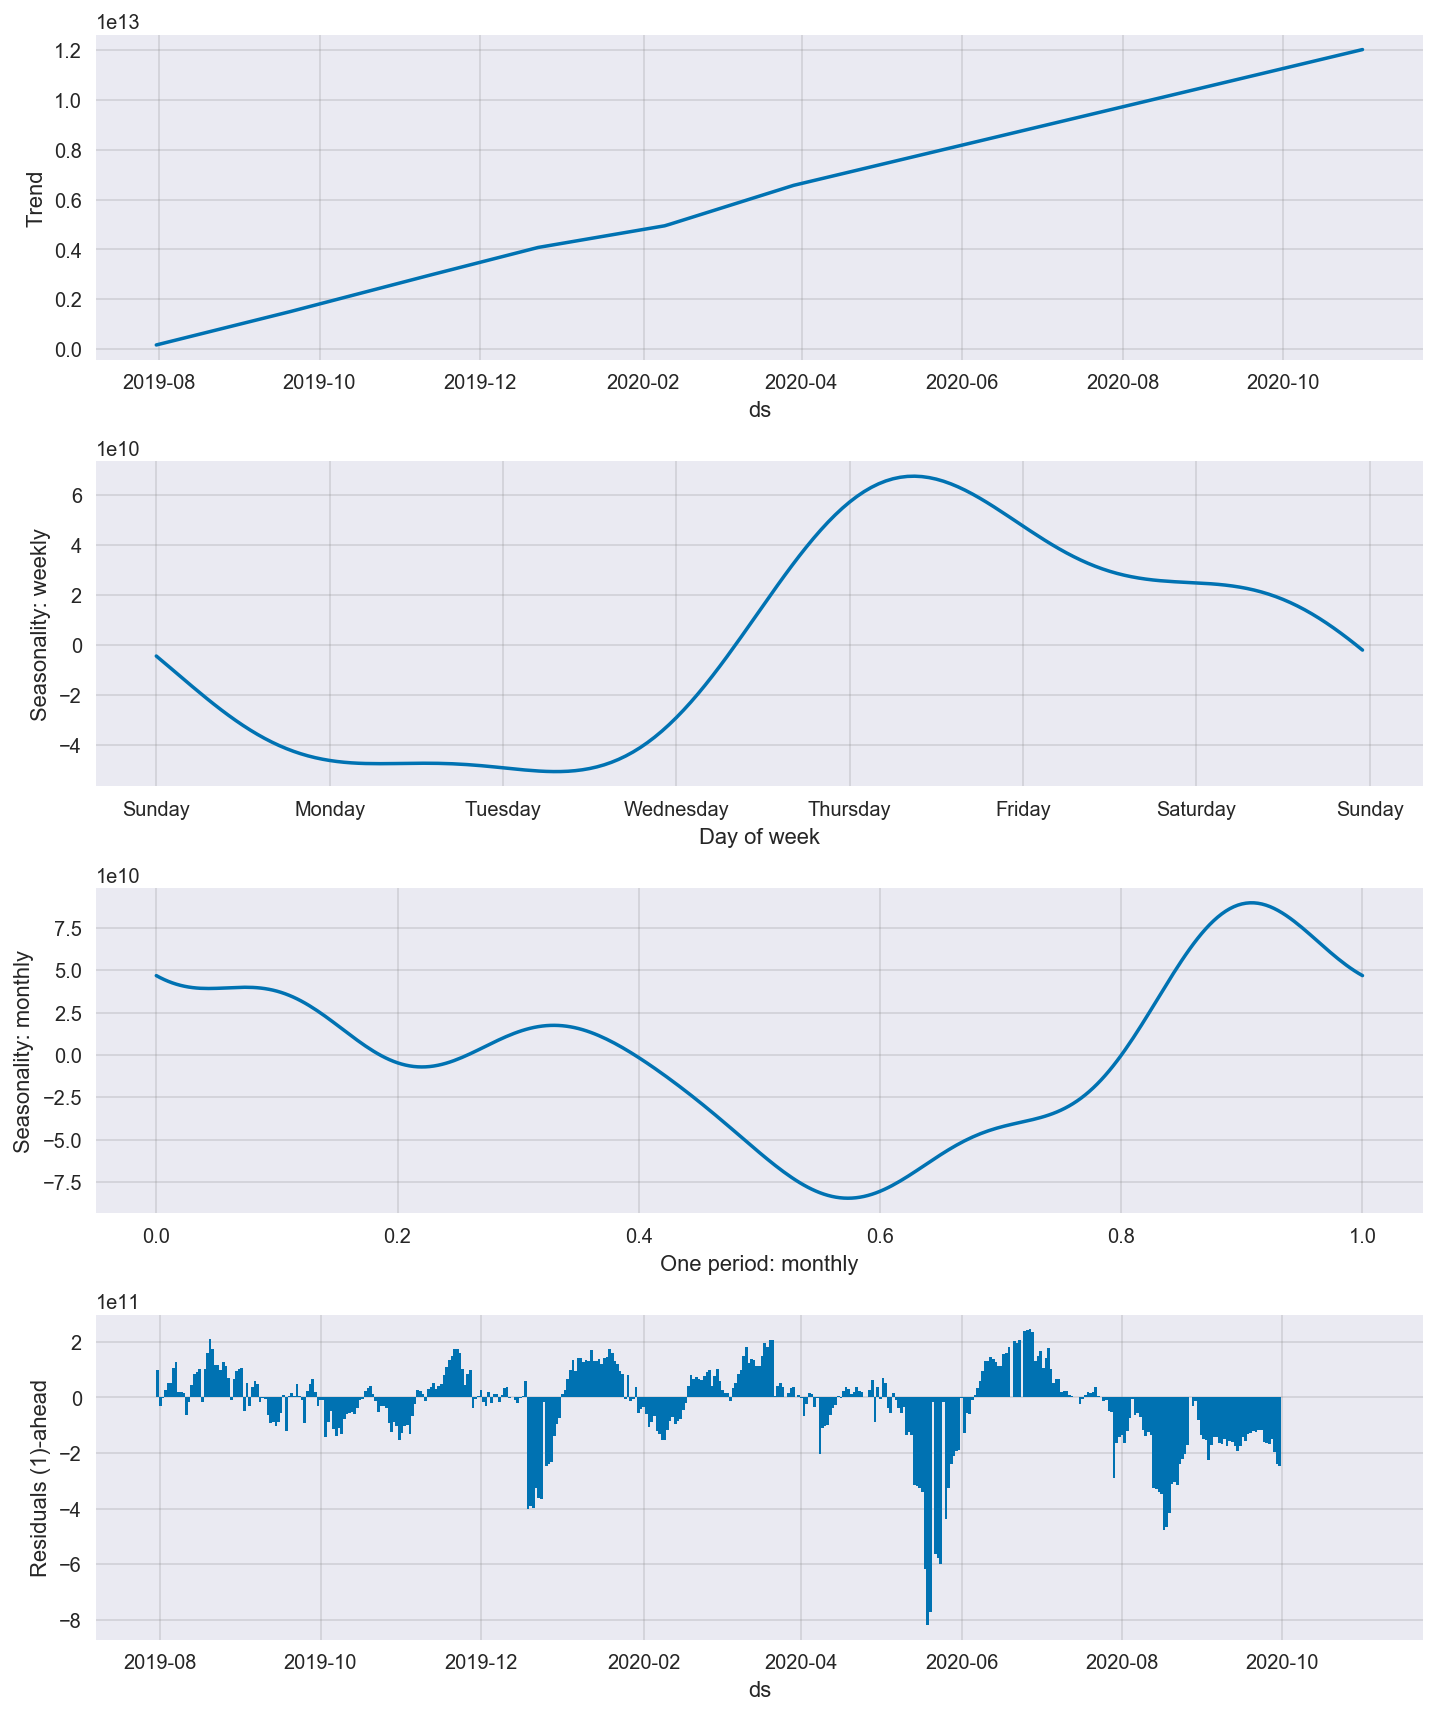

In [25]:
model_holiday_indo_kantor.plot_components(forecast_kantor, residuals=True);


In [26]:
daily_kas_kantor

,ds,y
0,2019-07-31,1.928940e+09
1,2019-08-01,2.492322e+11
2,2019-08-02,2.493411e+11
3,2019-08-03,2.493411e+11
4,2019-08-04,2.608817e+11
...,...,...
420,2020-09-26,1.123736e+13
421,2020-09-27,1.122373e+13
422,2020-09-28,1.126813e+13
423,2020-09-29,1.134856e+13


In [27]:
forecast_kantor

,ds,y,yhat1,residual1,trend,season_weekly,season_monthly
0,2019-07-31,1.928940e+09,1.002703e+11,9.834140e+10,1.711682e+11,-2.920557e+10,-4.169237e+10
1,2019-08-01,2.492322e+11,2.185818e+11,-3.065033e+10,1.973994e+11,5.716878e+10,-3.598632e+10
2,2019-08-02,2.493411e+11,2.477609e+11,-1.580176e+09,2.236306e+11,4.751556e+10,-2.338508e+10
3,2019-08-03,2.493411e+11,2.777270e+11,2.838590e+10,2.498616e+11,2.475963e+10,3.105831e+09
4,2019-08-04,2.608817e+11,3.114921e+11,5.061039e+10,2.760928e+11,-4.542132e+09,3.994149e+10
...,...,...,...,...,...,...,...
451,2020-10-27,NaN,1.178045e+13,NaN,1.191268e+13,-4.931793e+10,-8.291848e+10
452,2020-10-28,NaN,1.183696e+13,NaN,1.193788e+13,-2.920557e+10,-7.171233e+10
453,2020-10-29,NaN,1.194662e+13,NaN,1.196308e+13,5.716878e+10,-5.647161e+10
454,2020-10-30,NaN,1.199069e+13,NaN,1.198828e+13,4.751556e+10,-4.510669e+10


In [41]:
forecast_kantor['yhat1'].tail(31)

425    1.127153e+13
426    1.130088e+13
427    1.133099e+13
428    1.136314e+13
429    1.137972e+13
430    1.140633e+13
431    1.144321e+13
432    1.154085e+13
433    1.154240e+13
434    1.153801e+13
435    1.153131e+13
436    1.151241e+13
437    1.151647e+13
438    1.154851e+13
439    1.165516e+13
440    1.167014e+13
441    1.167587e+13
442    1.167514e+13
443    1.166232e+13
444    1.167520e+13
445    1.171489e+13
446    1.181960e+13
447    1.181779e+13
448    1.179595e+13
449    1.176917e+13
450    1.174432e+13
451    1.176382e+13
452    1.182392e+13
453    1.194054e+13
454    1.197860e+13
455    1.198430e+13
Name: yhat1, dtype: float64

In [55]:
submission = forecast_kantor['yhat1'].tail(31).reset_index(drop=True)
submission.to_csv('neuralprophet-kantor.csv',index_label='index',header=['value'])

# Neural Prophet Model - Echannel

In [42]:
daily_kas_echannel = cash[['periode', 'kas_echannel']].rename(
    columns={'periode': 'ds',
             'kas_echannel': 'y'})
# daily_kas_echannel = cash[['periode', 'kas_echannel']].head(int(len(cash)*(80/100))).rename(
#     columns={'periode': 'ds',
#              'kas_echannel': 'y'})

daily_kas_echannel.head()

,ds,y
0,2019-07-31,2.939100e+09
1,2019-08-01,2.839150e+09
2,2019-08-02,3.387550e+09
3,2019-08-03,3.876950e+09
4,2019-08-04,3.874250e+09


In [65]:
Kemerdekaan = pd.DataFrame({
    'holiday': 'Kemerdekaan',
    'ds': pd.to_datetime(['2020-08-19', # past date, historical data 
                          '2021-08-19']), # future date, to be forecasted
    'lower_window': 0, # include 27th - 31st December
    'upper_window': 4})

Natal = pd.DataFrame({
    'holiday': 'Natal',
    'ds': pd.to_datetime(['2020-12-25', # past date, historical data 
                          '2021-12-25']), # future date, to be forecasted
    'lower_window': -1, # include 27th - 31st December
    'upper_window': 6})

Nyepi = pd.DataFrame({
    'holiday': 'Nyepi',
    'ds': pd.to_datetime(['2020-03-25', # past date, historical data 
                          '2021-03-14']), # future date, to be forecasted
    'lower_window': 0, # include 27th - 31st December
    'upper_window': 1})


holiday_echannel = pd.concat([Kemerdekaan,Natal, Nyepi], axis=0).reset_index(drop=True)
holiday_echannel

,holiday,ds,lower_window,upper_window
0,Kemerdekaan,2020-08-19,0,4
1,Kemerdekaan,2021-08-19,0,4
2,Natal,2020-12-25,-1,6
3,Natal,2021-12-25,-1,6
4,Nyepi,2020-03-25,0,1
5,Nyepi,2021-03-14,0,1


In [44]:
# See some dates that become outlier

daily_kas_echannel[daily_kas_echannel['y'] > 7e+09]

,ds,y
383,2020-08-19,7.019300e+09
384,2020-08-20,8.183350e+09
385,2020-08-21,8.857000e+09
386,2020-08-22,9.070650e+09
387,2020-08-23,7.167200e+09


In [82]:

model_holiday_indo_echannel = NeuralProphet(
    growth='linear',
    changepoints=None,
    n_changepoints=8,
    changepoints_range=0.5,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='additive',
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0,
    num_hidden_layers=16,
    d_hidden=32,
    ar_sparsity=None,
    learning_rate=None,
    epochs=None,
    batch_size=None,
    loss_func='Huber',
    train_speed=None,
    normalize='auto',
    impute_missing=True,
    log_level=None)
# model_holiday_indo_echannel.add_events(holiday_echannel)
model_holiday_indo_echannel.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_holiday_indo_echannel.add_country_holidays(country_name='ID')
model_holiday_indo_echannel.fit(daily_kas_echannel, freq="D",validate_each_epoch=True,valid_p=0.2,)

future_echannel = model_holiday_indo_echannel.make_future_dataframe(daily_kas_echannel, 
                                                 periods = test_length, 
                                                 n_historic_predictions=len(daily_kas_echannel))
# forecasting
forecast_echannel = model_holiday_indo_echannel.predict(future_echannel)


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py", l

  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Users\farha\Anaconda3\en

  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\asyncio\base_events.py", line 534, in run_forever
    self._run_once()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\asyncio\base_events.py", line 1771, in _run_once
    handle._run()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
    re

INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 8

INFO: nprophet.config - set_auto_batch_epoch: Auto-set epochs to 94
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\farha\Anaco

  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.85E-01
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\

Epoch[94/94]: 100%|█| 94/94 [00:06<00:00, 14.58it/s, SmoothL1Loss=0.0199, MAE=3.59e+8, RegLoss=0, MAE_val=2.03e+9, Smoo
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 1025, in emit
    msg = self.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 869, in format
    return fmt.format(record)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 608, in format
    record.message = record.getMessage()
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\farha\Anaconda3\envs\tensorflow_gpu\lib\runpy.py", line 85, in _run_code
    

MSE comparison ----
NeuralProphet:	0.2818


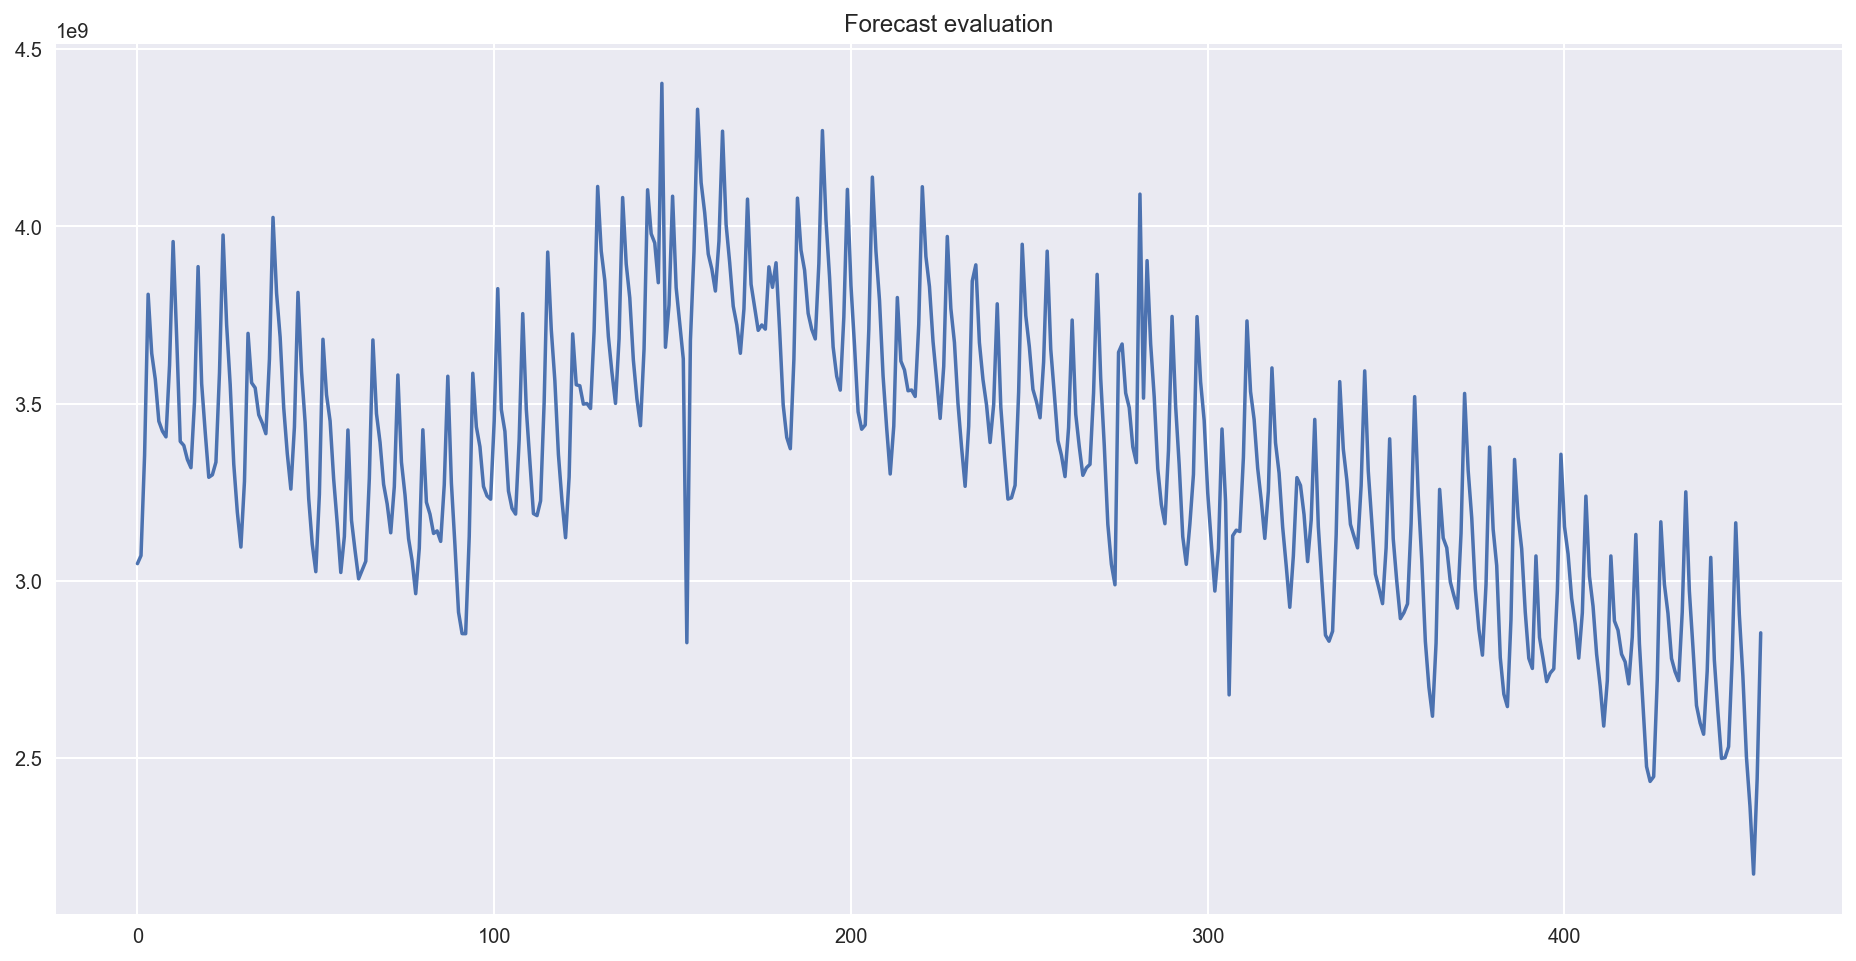

In [83]:
# I know about chained indexing here, but it was just faster and more elegant then using iloc and column index
from sklearn.metrics import mean_squared_log_error

# prepping the DataFrame
forecast= forecast_echannel.loc[:, 'yhat1']
# forecast_kantor.set_index('ds', inplace=True)

print('MSE comparison ----')
# print(f"NeuralProphet:\t{mean_squared_error(forecast_kantor['y'], forecast_kantor.iloc[-test_length:]['yhat1']):.4f}")
print(f"NeuralProphet:\t{np.sqrt(mean_squared_log_error(forecast_echannel['yhat1'].head(425),daily_kas_echannel.loc[:,'y'])):.4f}")

forecast.plot(title='Forecast evaluation');

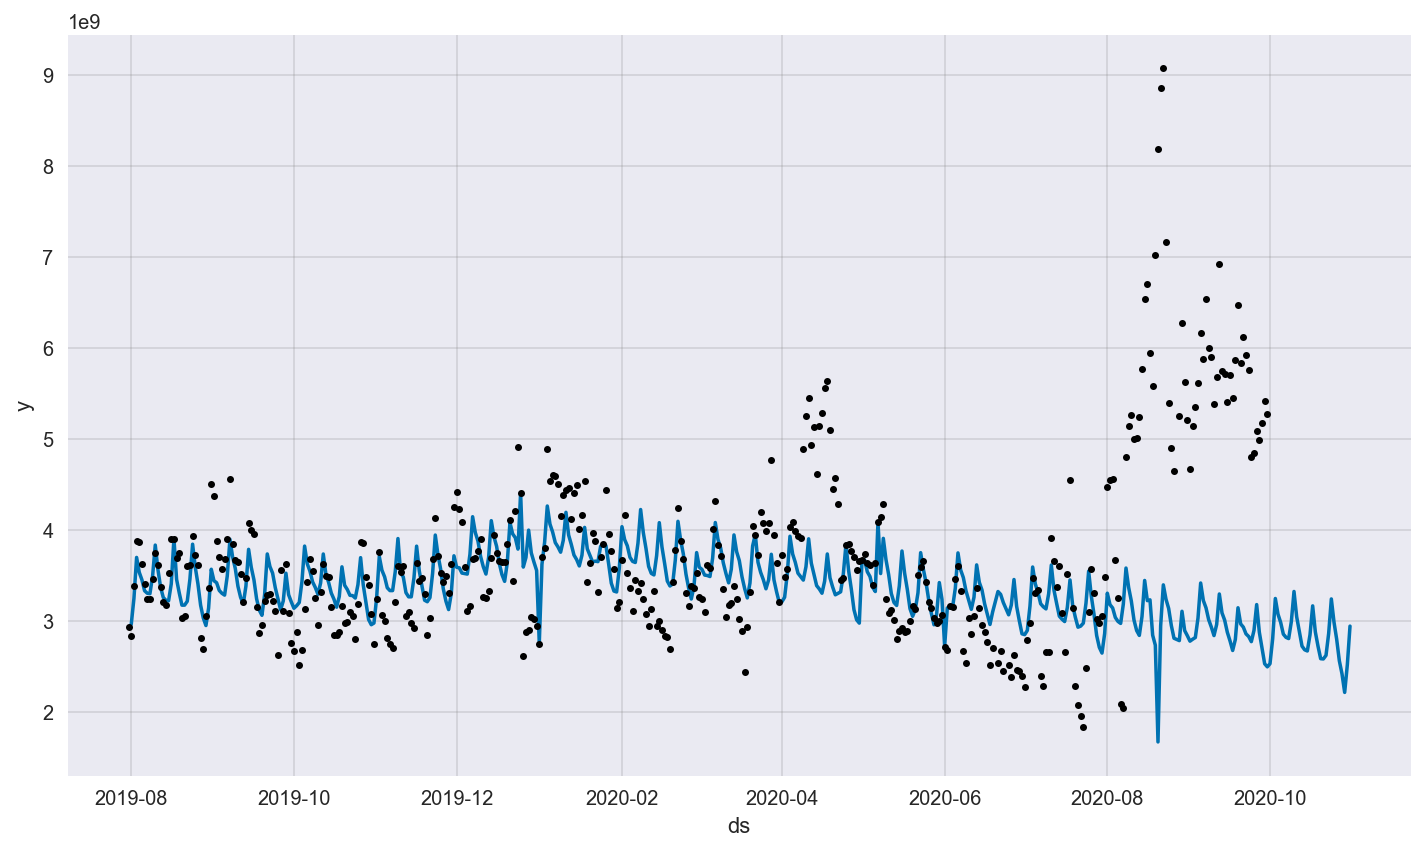

In [75]:
model_holiday_indo_echannel.plot(forecast_echannel);

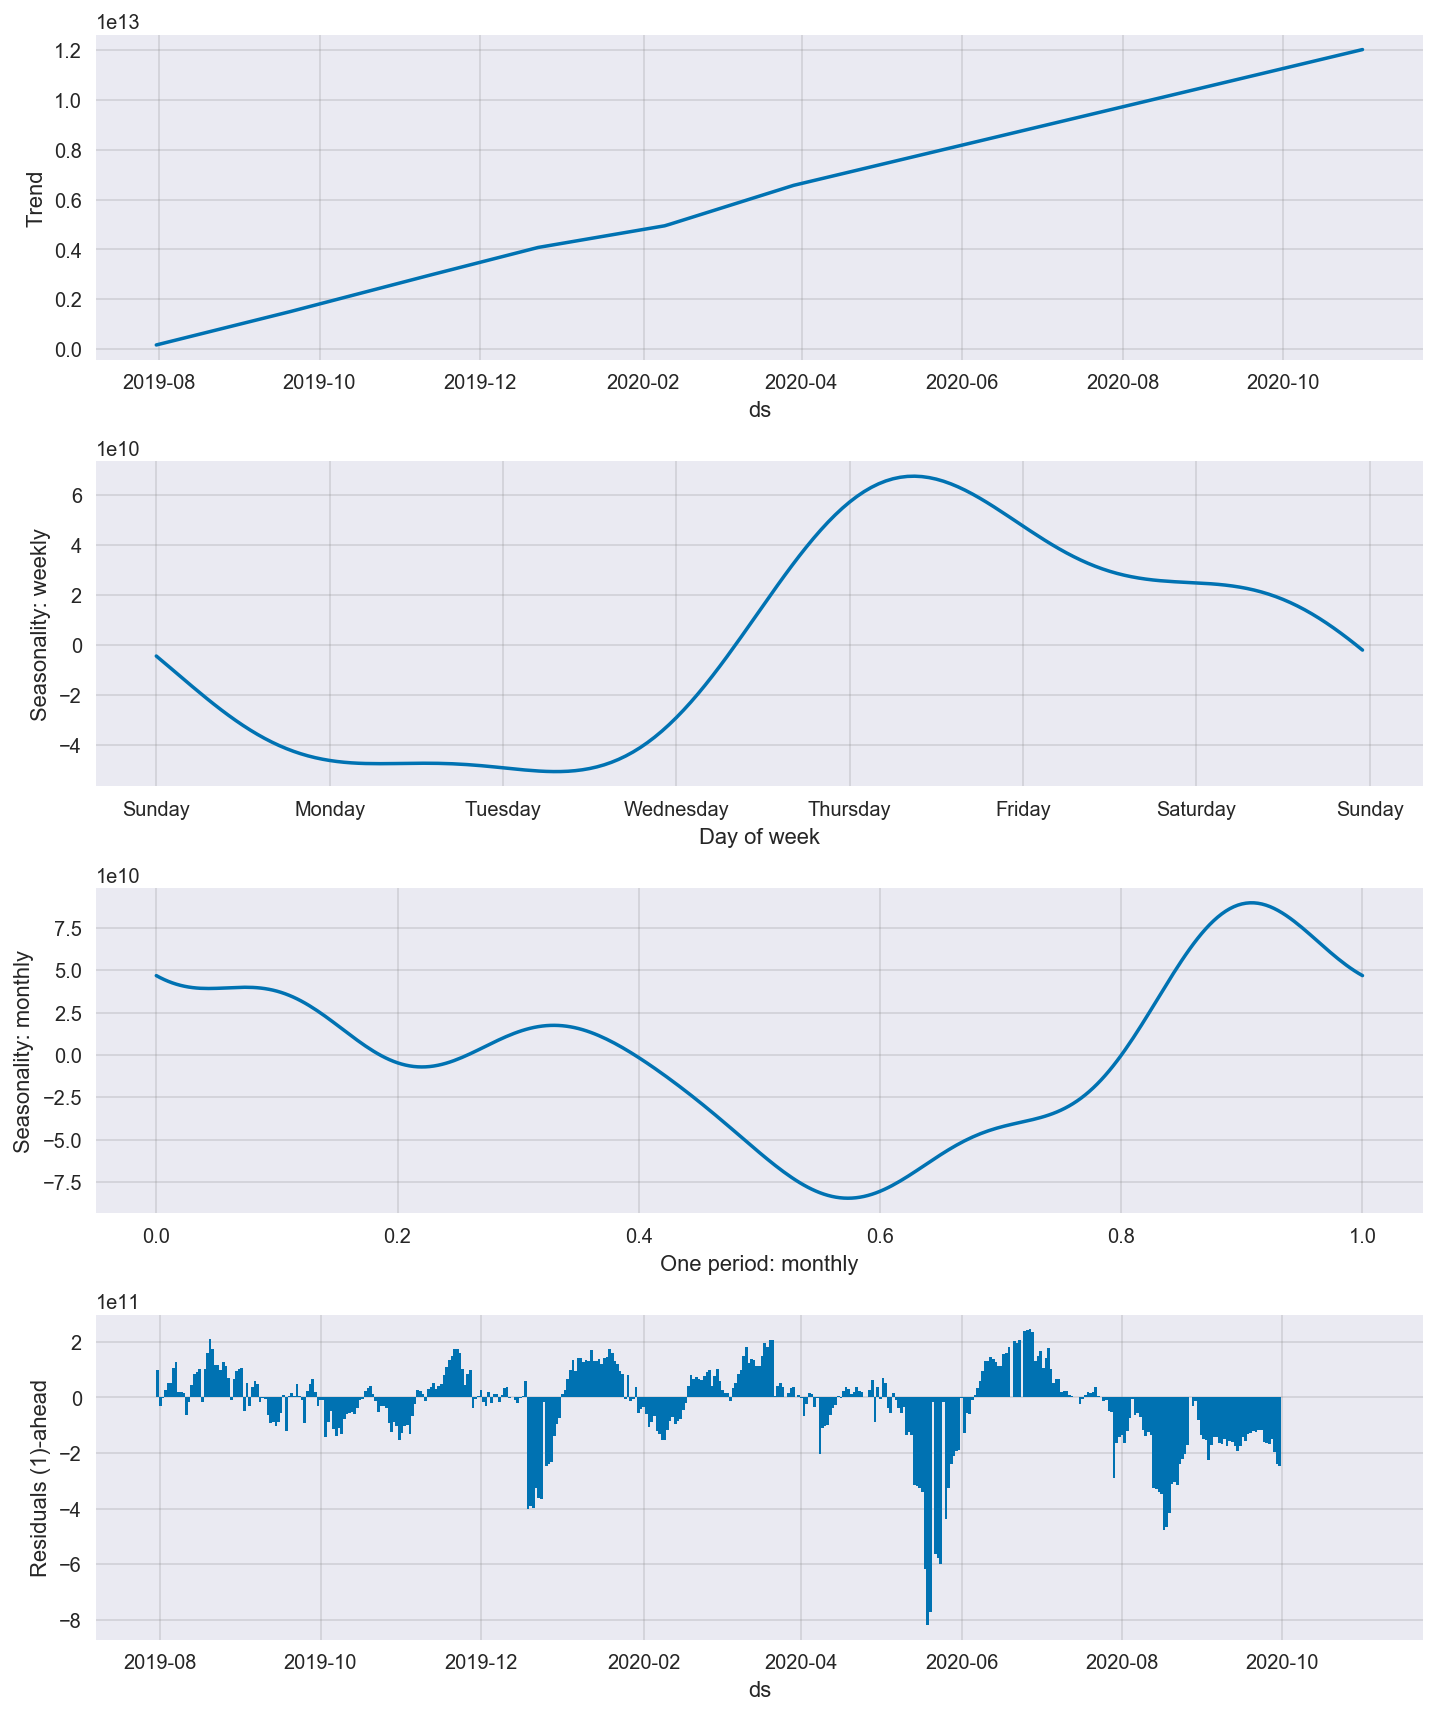

In [25]:
model_holiday_indo_kantor.plot_components(forecast_kantor, residuals=True);


In [76]:
daily_kas_echannel

,ds,y
0,2019-07-31,2.939100e+09
1,2019-08-01,2.839150e+09
2,2019-08-02,3.387550e+09
3,2019-08-03,3.876950e+09
4,2019-08-04,3.874250e+09
...,...,...
420,2020-09-26,5.085800e+09
421,2020-09-27,4.994300e+09
422,2020-09-28,5.181900e+09
423,2020-09-29,5.419050e+09


In [77]:
forecast_echannel

,ds,y,yhat1,residual1,trend,season_weekly,season_monthly
0,2019-07-31,2.939100e+09,2.925845e+09,-13255264.0,3.307736e+09,-173192320.0,-208698624.0
1,2019-08-01,2.839150e+09,2.968182e+09,129032016.0,3.312577e+09,-209932896.0,-134462272.0
2,2019-08-02,3.387550e+09,3.250337e+09,-137213232.0,3.317419e+09,-22474640.0,-44607484.0
3,2019-08-03,3.876950e+09,3.701457e+09,-175493104.0,3.322260e+09,349777920.0,29418558.0
4,2019-08-04,3.874250e+09,3.537360e+09,-336889872.0,3.327102e+09,138006736.0,72251632.0
...,...,...,...,...,...,...,...
451,2020-10-27,NaN,2.566385e+09,NaN,2.786864e+09,-112793816.0,-107685728.0
452,2020-10-28,NaN,2.422482e+09,NaN,2.783344e+09,-173192320.0,-187669728.0
453,2020-10-29,NaN,2.219084e+09,NaN,2.779824e+09,-209932896.0,-234290288.0
454,2020-10-30,NaN,2.523270e+09,NaN,2.776304e+09,-22474640.0,-230558816.0


In [78]:
forecast_kantor['yhat1'].tail(31)

425    1.127153e+13
426    1.130088e+13
427    1.133099e+13
428    1.136314e+13
429    1.137972e+13
430    1.140633e+13
431    1.144321e+13
432    1.154085e+13
433    1.154240e+13
434    1.153801e+13
435    1.153131e+13
436    1.151241e+13
437    1.151647e+13
438    1.154851e+13
439    1.165516e+13
440    1.167014e+13
441    1.167587e+13
442    1.167514e+13
443    1.166232e+13
444    1.167520e+13
445    1.171489e+13
446    1.181960e+13
447    1.181779e+13
448    1.179595e+13
449    1.176917e+13
450    1.174432e+13
451    1.176382e+13
452    1.182392e+13
453    1.194054e+13
454    1.197860e+13
455    1.198430e+13
Name: yhat1, dtype: float64

In [80]:
submission = pd.concat([forecast_kantor['yhat1'].tail(31), forecast_echannel['yhat1'].tail(31)], axis=0).reset_index(drop=True)


In [81]:
submission.to_csv('test-np.csv',index_label='index',header=['value'])